<a href="https://colab.research.google.com/github/carlsec/machine_learning/blob/master/Head_CT_hemorrhage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if not os.path.exists('images'):
    !pip install -qU torch_snippets
    from google.colab import files
    files.upload() # upload kaggle.json
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d felipekitamura/head-ct-hemorrhage
    !unzip -qq head-ct-hemorrhage.zip
    !rm head-ct-hemorrhage.zip

     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 204kB 30.1MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 


Saving kaggle.json to kaggle.json
kaggle.json
 37% 9.00M/24.4M [00:00<00:00, 43.8MB/s]
100% 24.4M/24.4M [00:00<00:00, 80.6MB/s]


In [ ]:
from torch_snippets import *
from PIL import Image
from sklearn.utils import shuffle
import albumentations as A
IMAGE_ROOT = '/content/head_ct/head_ct'
df = pd.read_csv('labels.csv')

[04/14/21 23:53:57] WARNING  Not importing Lightning Report      ]8;id=1618444437.370244-578162;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/torch_loader.py\torch_loader.py]8;;\:<module>:233

                    WARNING  sklearn is not found. Skipping relevant  ]8;id=1618444437.976442-138609;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/__init__.py\__init__.py]8;;\:<module>:13
                             imports from submodule `sklegos`

In [ ]:
!pip install timm
import timm

     |████████████████████████████████| 296kB 18.8MB/s 


In [ ]:
df.head()

,id,hemorrhage
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [ ]:
df.tail()

,id,hemorrhage
195,195,0
196,196,0
197,197,0
198,198,0
199,199,0


In [ ]:
list_id = list(os.listdir(IMAGE_ROOT))
df['id'] = sorted(list_id)
df.head(20)

,id,hemorrhage
0,000.png,1
1,001.png,1
2,002.png,1
3,003.png,1
4,004.png,1
5,005.png,1
6,006.png,1
7,007.png,1
8,008.png,1
9,009.png,1


# New Section

In [ ]:
class headData(Dataset):
  def __init__(self, df, image_dir=IMAGE_ROOT, transform=None):
    self.image_dir = image_dir
    self.files = glob.glob(self.image_dir+'/*')
    self.df = df
    self.image_infos = df.id.unique()
    self.transform = transform

  def __getitem__(self, index):
    image_id = self.image_infos[index]
    image_path = find(image_id, self.files)
    img = np.array(Image.open(image_path).convert("RGB"))
    data = self.df[self.df['id'] == image_id]
    label = data[' hemorrhage'].values.tolist()

    if self.transform is not None:
      image = self.transform(image=img)["image"]

    return torch.tensor(image/255).permute(2,0,1).float().to(device), torch.tensor(label).float().to(device)

  def __len__(self):
    return len(self.image_infos)

In [ ]:
train_transform = A.Compose(
    [   A.Resize(320,320),
        A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.02, rotate_limit=15, p=0.2),
        A.RandomCrop(height=300, width=300),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.2),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
        A.IAAAdditiveGaussianNoise(),
        A.GaussNoise(),
        ], p=0.2),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

val_transform = A.Compose(
    [   A.Resize(320,320),
        A.CenterCrop(height=300, width=300),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

In [ ]:
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.id.unique(), test_size=0.3, random_state=45)
trn_df, val_df = shuffle(df[df['id'].isin(trn_ids)]).reset_index(drop = True), shuffle(df[df['id'].isin(val_ids)]).reset_index(drop = True)
len(trn_df), len(val_df)

train_ds = headData(trn_df, transform=train_transform)
test_ds = headData(val_df, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=8, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=8, drop_last=True)

In [ ]:
names_of_labels = {1: 'Yes', 0: 'No'}

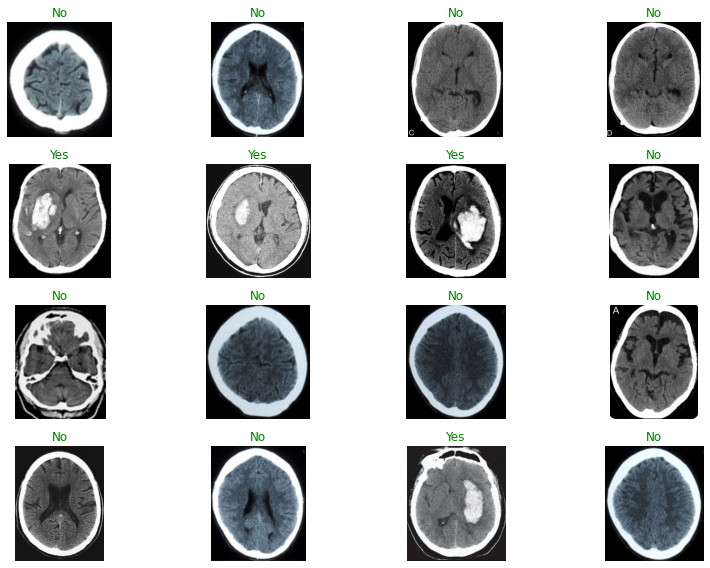

In [ ]:
def display_image_grid(df, predicted_labels=(), image_dir = IMAGE_ROOT, rows=4, cols=4):
    files = glob.glob(image_dir+'/*')
    image_infos = df.id.unique()
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for index in range(rows*cols):
        image_id = image_infos[index]
        image_path = find(image_id, files)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = names_of_labels[df[' hemorrhage'][index]]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[index].imshow(image)
        ax.ravel()[index].set_title(predicted_label, color=color)
        ax.ravel()[index].set_axis_off()
    plt.tight_layout()
    plt.show()
    
display_image_grid(val_df, rows=4, cols=4)  

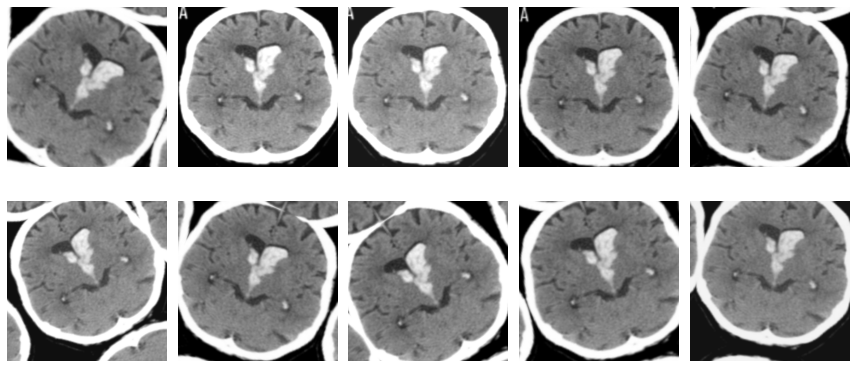

In [ ]:
def visualize_augmentations(dataset, idx=1, samples=10, cols=5):
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        image = image.permute(1,2,0)
        ax.ravel()[i].imshow((image).cpu().detach().numpy())
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_augmentations(train_ds)

In [ ]:
class ResNet200D(nn.Module):
    def __init__(self, model_name='resnet200d'):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        for param in self.model.parameters():
            param.requires_grad = True
        n_features = self.model.fc.in_features
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(n_features, 1)

    def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        pooled_features = self.pooling(features).view(bs, -1)
        output = self.fc(pooled_features)

        return output

In [ ]:
!pip install torch_summary
from torchsummary import summary
model = ResNet200D().to(device)
summary(model, torch.zeros(1,3,224,224));

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 2048, 7, 7]          --
|    └─Sequential: 2-1                   [-1, 64, 112, 112]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 112, 112]        864
|    |    └─BatchNorm2d: 3-2             [-1, 32, 112, 112]        64
|    |    └─ReLU: 3-3                    [-1, 32, 112, 112]        --
|    |    └─Conv2d: 3-4                  [-1, 32, 112, 112]        9,216
|    |    └─BatchNorm2d: 3-5             [-1, 32, 112, 112]        64
|    |    └─ReLU: 3-6                    [-1, 32, 112, 112]        --
|    |    └─Conv2d: 3-7                  [-1, 64, 112, 112]        18,432
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |

In [ ]:
model = ResNet200D().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction >= 0.5) == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()  

In [ ]:
for epoch in range(50):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(train_loader)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(train_loader)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(test_loader)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Training Epoch: {epoch}, 'LR:', {scheduler.get_last_lr()}")
    print(f"Train Losses: {train_epoch_loss}")
    print(f"Train Accuracy: {train_epoch_accuracy}")
    print(f"Val Losses: {validation_loss}")
    print(f"Val Accuracy: {val_epoch_accuracy}")
    print("-------------------------------------------------------------")
    scheduler.step()

Training Epoch: 0, 'LR:', [0.01]

Train Losses: 1.1434904617421768

Train Accuracy: 0.6176470588235294

Val Losses: 0.46585896611213684

Val Accuracy: 0.6964285714285714

-------------------------------------------------------------

Training Epoch: 1, 'LR:', [0.01]

Train Losses: 0.6968699623556698

Train Accuracy: 0.6397058823529411

Val Losses: 0.2980431318283081

Val Accuracy: 0.6607142857142857

-------------------------------------------------------------

Training Epoch: 2, 'LR:', [0.01]

Train Losses: 0.7175706116592183

Train Accuracy: 0.6397058823529411

Val Losses: 0.42922738194465637

Val Accuracy: 0.7321428571428571

-------------------------------------------------------------

Training Epoch: 3, 'LR:', [0.01]

Train Losses: 0.7159202975385329

Train Accuracy: 0.6102941176470589

Val Losses: 0.457489550113678

Val Accuracy: 0.75

-------------------------------------------------------------

Training Epoch: 4, 'LR:', [0.01]

Train Losses: 0.7875234098995433

Train Accuracy: 0.6176470588235294

Val Losses: 0.5825324058532715

Val Accuracy: 0.6785714285714286

-------------------------------------------------------------

Training Epoch: 5, 'LR:', [0.01]

Train Losses: 0.6272714628892786

Train Accuracy: 0.5367647058823529

Val Losses: 0.4793739318847656

Val Accuracy: 0.5714285714285714

-------------------------------------------------------------

Training Epoch: 6, 'LR:', [0.01]

Train Losses: 0.7134014929042143

Train Accuracy: 0.5441176470588235

Val Losses: 0.5763593912124634

Val Accuracy: 0.5357142857142857

-------------------------------------------------------------

Training Epoch: 7, 'LR:', [0.01]

Train Losses: 0.676303926636191

Train Accuracy: 0.6470588235294118

Val Losses: 0.43722233176231384

Val Accuracy: 0.625

-------------------------------------------------------------

Training Epoch: 8, 'LR:', [0.01]

Train Losses: 0.62454094080364

Train Accuracy: 0.6029411764705882

Val Losses: 0.45603352785110474

Val Accuracy: 0.6607142857142857

-------------------------------------------------------------

Training Epoch: 9, 'LR:', [0.01]

Train Losses: 0.66087507500368

Train Accuracy: 0.6838235294117647

Val Losses: 0.44955313205718994

Val Accuracy: 0.7142857142857143

-------------------------------------------------------------

Training Epoch: 10, 'LR:', [0.001]

Train Losses: 0.5116917745155447

Train Accuracy: 0.7352941176470589

Val Losses: 0.35099953413009644

Val Accuracy: 0.75

-------------------------------------------------------------

Training Epoch: 11, 'LR:', [0.001]

Train Losses: 0.478577683077139

Train Accuracy: 0.7647058823529411

Val Losses: 0.33356550335884094

Val Accuracy: 0.7678571428571429

-------------------------------------------------------------

Training Epoch: 12, 'LR:', [0.001]

Train Losses: 0.4404638085295172

Train Accuracy: 0.7941176470588235

Val Losses: 0.3497154414653778

Val Accuracy: 0.7678571428571429

-------------------------------------------------------------

Training Epoch: 13, 'LR:', [0.001]

Train Losses: 0.4113811035366619

Train Accuracy: 0.7426470588235294

Val Losses: 0.32467228174209595

Val Accuracy: 0.7678571428571429

-------------------------------------------------------------

Training Epoch: 14, 'LR:', [0.001]

Train Losses: 0.47516797921236825

Train Accuracy: 0.8308823529411765

Val Losses: 0.29639315605163574

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 15, 'LR:', [0.001]

Train Losses: 0.4289655185797635

Train Accuracy: 0.8308823529411765

Val Losses: 0.28528356552124023

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 16, 'LR:', [0.001]

Train Losses: 0.3705332892782548

Train Accuracy: 0.8823529411764706

Val Losses: 0.29695236682891846

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 17, 'LR:', [0.001]

Train Losses: 0.36719931705909614

Train Accuracy: 0.8014705882352942

Val Losses: 0.3400224447250366

Val Accuracy: 0.7857142857142857

-------------------------------------------------------------

Training Epoch: 18, 'LR:', [0.001]

Train Losses: 0.43884970466880235

Train Accuracy: 0.8602941176470589

Val Losses: 0.3377001881599426

Val Accuracy: 0.7857142857142857

-------------------------------------------------------------

Training Epoch: 19, 'LR:', [0.001]

Train Losses: 0.39056350992006417

Train Accuracy: 0.8529411764705882

Val Losses: 0.34402841329574585

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 20, 'LR:', [0.0001]

Train Losses: 0.3817829735138837

Train Accuracy: 0.8823529411764706

Val Losses: 0.34801727533340454

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 21, 'LR:', [0.0001]

Train Losses: 0.3555205701028599

Train Accuracy: 0.875

Val Losses: 0.3346891403198242

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 22, 'LR:', [0.0001]

Train Losses: 0.3599713453475167

Train Accuracy: 0.8602941176470589

Val Losses: 0.3352581560611725

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 23, 'LR:', [0.0001]

Train Losses: 0.37558481491663875

Train Accuracy: 0.8308823529411765

Val Losses: 0.35038670897483826

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 24, 'LR:', [0.0001]

Train Losses: 0.3712735636269345

Train Accuracy: 0.8897058823529411

Val Losses: 0.35248127579689026

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 25, 'LR:', [0.0001]

Train Losses: 0.33389569205396313

Train Accuracy: 0.8602941176470589

Val Losses: 0.3543577492237091

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 26, 'LR:', [0.0001]

Train Losses: 0.34786050372263966

Train Accuracy: 0.875

Val Losses: 0.35896530747413635

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 27, 'LR:', [0.0001]

Train Losses: 0.33790604507221894

Train Accuracy: 0.8602941176470589

Val Losses: 0.3592638373374939

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 28, 'LR:', [0.0001]

Train Losses: 0.34756145144210143

Train Accuracy: 0.8823529411764706

Val Losses: 0.3572181463241577

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 29, 'LR:', [0.0001]

Train Losses: 0.36316175408223095

Train Accuracy: 0.8897058823529411

Val Losses: 0.3464565873146057

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 30, 'LR:', [1e-05]

Train Losses: 0.3417227325194022

Train Accuracy: 0.875

Val Losses: 0.3451078534126282

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 31, 'LR:', [1e-05]

Train Losses: 0.344045024146052

Train Accuracy: 0.8382352941176471

Val Losses: 0.34522464871406555

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 32, 'LR:', [1e-05]

Train Losses: 0.38483743895502653

Train Accuracy: 0.8308823529411765

Val Losses: 0.3462633192539215

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 33, 'LR:', [1e-05]

Train Losses: 0.31452053653843265

Train Accuracy: 0.8897058823529411

Val Losses: 0.34630319476127625

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 34, 'LR:', [1e-05]

Train Losses: 0.3908589394653545

Train Accuracy: 0.8676470588235294

Val Losses: 0.34690165519714355

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 35, 'LR:', [1e-05]

Train Losses: 0.34060562796452465

Train Accuracy: 0.875

Val Losses: 0.34691521525382996

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 36, 'LR:', [1e-05]

Train Losses: 0.3272092298549764

Train Accuracy: 0.9044117647058824

Val Losses: 0.3475087285041809

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 37, 'LR:', [1e-05]

Train Losses: 0.3196482982705621

Train Accuracy: 0.8823529411764706

Val Losses: 0.34824448823928833

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 38, 'LR:', [1e-05]

Train Losses: 0.3568284827120164

Train Accuracy: 0.8676470588235294

Val Losses: 0.3492223024368286

Val Accuracy: 0.8035714285714286

-------------------------------------------------------------

Training Epoch: 39, 'LR:', [1e-05]

Train Losses: 0.3843451628790182

Train Accuracy: 0.8382352941176471

Val Losses: 0.34983348846435547

Val Accuracy: 0.8214285714285714

-------------------------------------------------------------

Training Epoch: 40, 'LR:', [1.0000000000000002e-06]

Train Losses: 0.3270830433158314

Train Accuracy: 0.8676470588235294

Val Losses: 0.3500281572341919

Val Accuracy: 0.8214285714285714

-------------------------------------------------------------

Training Epoch: 41, 'LR:', [1.0000000000000002e-06]

Train Losses: 0.33871641316834616

Train Accuracy: 0.8455882352941176

Val Losses: 0.35017675161361694

Val Accuracy: 0.8214285714285714

-------------------------------------------------------------

Training Epoch: 42, 'LR:', [1.0000000000000002e-06]

Train Losses: 0.3329591260236852

Train Accuracy: 0.8970588235294118

Val Losses: 0.35026416182518005

Val Accuracy: 0.8214285714285714

-------------------------------------------------------------

Training Epoch: 43, 'LR:', [1.0000000000000002e-06]

Train Losses: 0.3531329202301362

Train Accuracy: 0.8676470588235294

Val Losses: 0.3502872586250305

Val Accuracy: 0.8214285714285714

-------------------------------------------------------------

Training Epoch: 44, 'LR:', [1.0000000000000002e-06]

Train Losses: 0.35805752522805157

Train Accuracy: 0.8676470588235294

Val Losses: 0.3503054678440094

Val Accuracy: 0.8214285714285714

-------------------------------------------------------------

Training Epoch: 45, 'LR:', [1.0000000000000002e-06]

Train Losses: 0.3325767977272763

Train Accuracy: 0.8382352941176471

Val Losses: 0.3503492474555969

Val Accuracy: 0.8214285714285714

-------------------------------------------------------------

Training Epoch: 46, 'LR:', [1.0000000000000002e-06]

Train Losses: 0.3891728301258648

Train Accuracy: 0.8823529411764706

Val Losses: 0.3504311442375183

Val Accuracy: 0.8214285714285714

-------------------------------------------------------------

Training Epoch: 47, 'LR:', [1.0000000000000002e-06]

Train Losses: 0.3415691913927303

Train Accuracy: 0.8308823529411765

Val Losses: 0.35049256682395935

Val Accuracy: 0.8214285714285714

-------------------------------------------------------------

Training Epoch: 48, 'LR:', [1.0000000000000002e-06]

Train Losses: 0.3315191593240289

Train Accuracy: 0.8676470588235294

Val Losses: 0.35048121213912964

Val Accuracy: 0.8214285714285714

-------------------------------------------------------------

Training Epoch: 49, 'LR:', [1.0000000000000002e-06]

Train Losses: 0.35350725317702575

Train Accuracy: 0.9044117647058824

Val Losses: 0.350422739982605

Val Accuracy: 0.8214285714285714

-------------------------------------------------------------